# Import Libraries


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt



---

#Load and Prepare CIFAR-10 Data
Here, I load the CIFAR-10 dataset. Convolutional layers work directly with the 2D structure of the images. I normalized the pixel values to be between 0 and 1 by dividing by 255.
The shape of our data will be `(num_samples, 32, 32, 3)`.

In [ ]:
(x_train, _), (x_test, _) = cifar10.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples




---
# Define the Encoder Architecture
The encoder's job is to compress the input image into a smaller, dense representation. We use a stack of Conv2D layers to learn features and MaxPooling2D layers to downsample the image dimensions. The image starts at 32x32x3 and is compressed down to 4x4x128.


In [ ]:
input_img = Input(shape=(32, 32, 3))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)



---
# Define the Decoder Architecture
The decoder reconstructs the image from the compressed representation. It's essentially a mirror image of the encoder. We use UpSampling2D to increase the dimensions and Conv2D layers to refine the image details. The final layer uses a sigmoid activation to ensure the output pixel values are in the range [0, 1].


In [ ]:
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)



---
# Create and Compile the Autoencoder Model
Now we define the full autoencoder model by specifying its input and output. We compile the model using the adam optimizer and binary_crossentropy as the loss function, which works well for comparing pixel values.


In [ ]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,955 (1.27 MB)

 Trainable params: 333,955 (1.27 MB)

 Non-trainable params: 0 (0.00 B)



---

# Train the Model
We train the model using the training data as both the input and the target. This is the core idea of an autoencoder: it learns to reconstruct its own input. We also use the test data for validation to monitor performance.

In [ ]:
history = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.6173 - val_loss: 0.5756
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.5737 - val_loss: 0.5709
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.5697 - val_loss: 0.5678
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.5665 - val_loss: 0.5682
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.5646 - val_loss: 0.5646
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.5642 - val_loss: 0.5642
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.5622 - val_loss: 0.5634
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.5619 - val_loss: 0.5616
Epoch 9/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.5611 - val_loss: 0.5650
Epoch 10/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.5609 - val_loss: 0.5605
Epoch 11/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.5600 - val_loss: 0.5605
Epoch 12/50
391/391 ━━━━━━━━━━━━━━━━━━━



---
# Plot Training History
This block visualizes the model's performance during training.


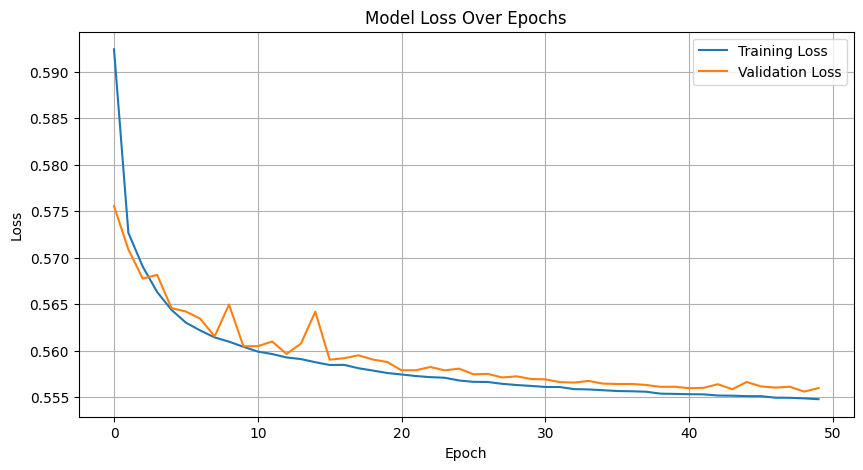

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()



---
# Visualize the Results
Finally, we use our trained autoencoder to reconstruct the images from the test set. We then plot the original images and their reconstructed versions side-by-side to visually inspect the quality of the reconstruction.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


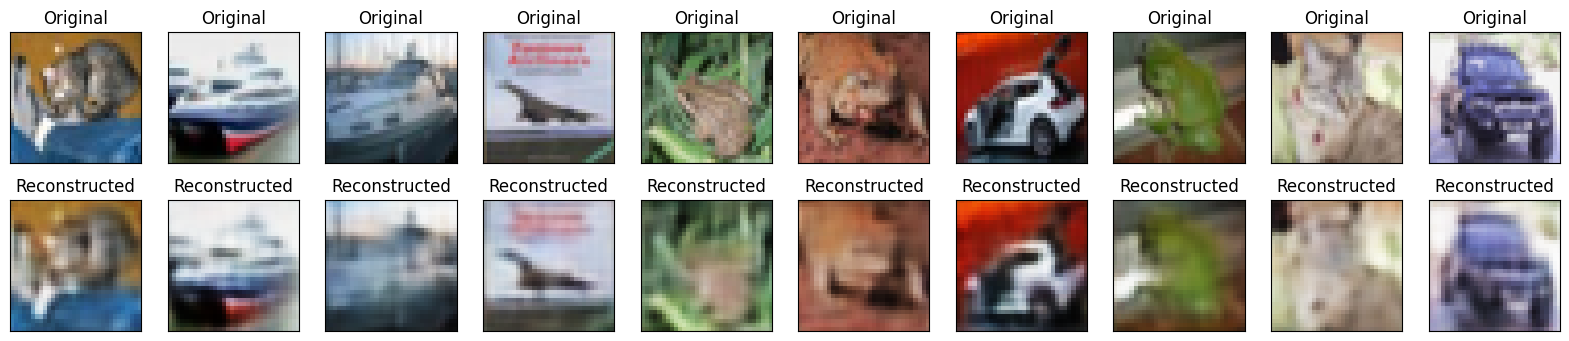

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("Original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("Reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()